The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [15]:
import pandas as pd
import numpy as np
import scipy as sp

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in four pieces. 

In [16]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')

We are now printing the columns.

In [17]:
print(real_power1.columns)


Index(['Datum', 'Uhrzeit', 'Gesamt (Netzlast)[MWh]', 'Residuallast[MWh]',
       'Pumpspeicher[MWh]'],
      dtype='object')


They are in German, thus we rename them with a dictionary. Besides dae, time and total power also resiuddal power and pump storage are available

In [18]:
#renaming columns
dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
real_power1.rename(columns=dic1,inplace=True)
real_power2.rename(columns=dic1,inplace=True)
real_power3.rename(columns=dic1,inplace=True)
real_power4.rename(columns=dic1,inplace=True)
print("columns after dictionary application")
print(real_power1.columns)


columns after dictionary application
Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage'], dtype='object')


Now I create a true date time column combining the date and time column and applying datetime methods.

In [19]:
real_power1['date_time']=pd.to_datetime(real_power1['Date'] + '.' + real_power1['Time'], format='%d.%m.%Y.%H:%M')
real_power2['date_time']=pd.to_datetime(real_power2['Date'] + '.' + real_power2['Time'], format='%d.%m.%Y.%H:%M')
real_power3['date_time']=pd.to_datetime(real_power3['Date'] + '.' + real_power3['Time'], format='%d.%m.%Y.%H:%M')
real_power4['date_time']=pd.to_datetime(real_power4['Date'] + '.' + real_power4['Time'], format='%d.%m.%Y.%H:%M')
print("The columns are")
print(real_power1.columns)
print("data types of columns")
print(real_power1.dtypes)

The columns are
Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage',
       'date_time'],
      dtype='object')
data types of columns
Date                      object
Time                      object
total_power              float64
residual_power           float64
pump_storage             float64
date_time         datetime64[ns]
dtype: object


As the next step I am combining the four different data sets and show the data in a plot. 

dimensions of the data are (276000, 6)


Text(0, 0.5, 'total power [GW]')

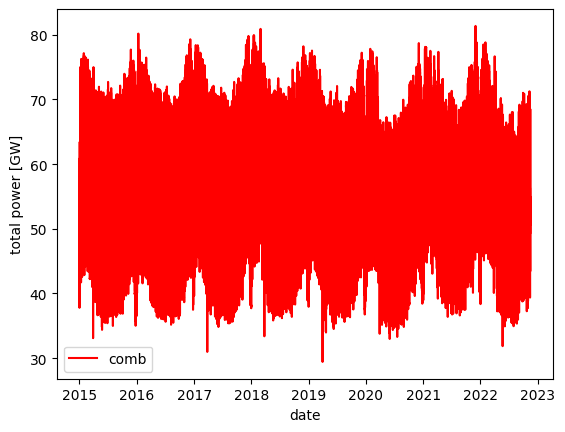

In [20]:
#date_time is set to index
real_power1=real_power1.set_index('date_time')
real_power2=real_power2.set_index('date_time')
real_power3=real_power3.set_index('date_time')
real_power4=real_power4.set_index('date_time')
#combining with concat
comb_real_power=pd.concat([real_power4,real_power3,real_power2,real_power1])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

In this plot are visible that there are yearly variations, that the consumption is usually larger in winter than in summer. At the smae it is clear that there are variations also on smaller timescales, since the range at each date is large. That cannot really be variation ata time. To see more of them I zoom in on a week. 

(18604.0, 18611.0)

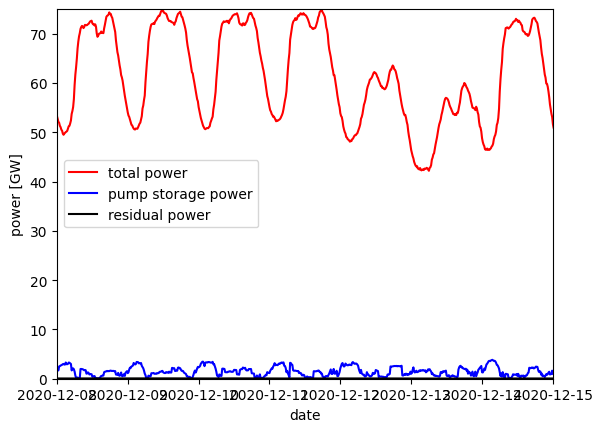

In [21]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0,75)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))

There are more cycles in the data, the strongest on the day time scale and likely another one on the time scale of a week. 

The periods are day, week and year.  From the 15 minutes sampling follows:

In [22]:
print(f"steps per day: {int(24*60/15)}")
print(f"steps per week: {int(7*24*60/15)}")
print(f"steps per year: {int(365.25*24*60/15)}")

steps per day: 96
steps per week: 672
steps per year: 35064




Below I look again on it this time use a logarithmic y-axis to be able to see more for the other two properties. 

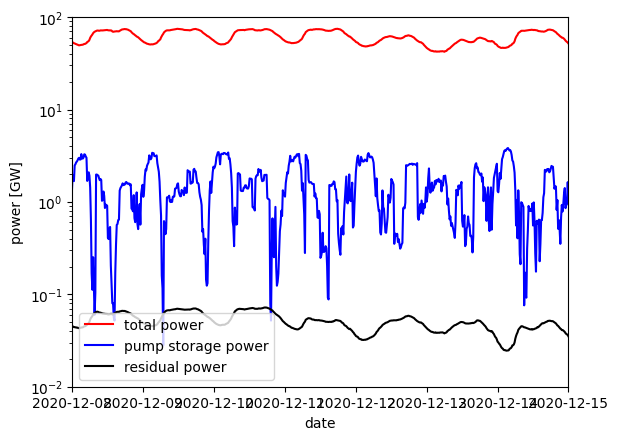

In [23]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0.01,100)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))
plt.yscale('log')


There is no clear connection of pump storage and residual power to total power and thus we ignore it for now.

As the next step we free space.

In [24]:
#real_power1=0
real_power2=0
real_power3=0
real_power4=0

The dataset is large. The causes that some models like Random Forest are too slow that they can be used on the full data set. I choose for fitting the two efficient options XGBoost regressor and linear regression. 

Xgboost needs to have the data transformed into the usual supervised data structure. Therefore, I use a function which uses some continous data block to predict one future data point. There can be a gap between the used data and the predicted data point or no gap. 

In [25]:
#parameters are: 
#data_frame, number of data points used for prediction, number of data points ignored between data and target, nan excluding
def series_to_supervised(data, n_in=1, offset=0, dropnan=True):
    #create empty data frame and list
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t+offset)
    for i in range(offset, 1+offset):
        cols.append(df.shift(-i))
    # connecting all 
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

As a first test I use the most recent 2 years as data and one day of data for predicting the next data point. 

In [26]:
power_2years=series_to_supervised(real_power1.total_power,96,0)
power_2years=pd.DataFrame(power_2years)

Now I split this data set in the training and test set. 

In [27]:
steps = 13250
print(f"{round(steps/power_2years.shape[0]*100,2)} % are used in test")
data_train = power_2years.iloc[:-steps,:]
data_test  = power_2years.iloc[-steps:,:]
x_train=data_train.iloc[:,0:96]
x_test=data_test.iloc[:,0:96]
y_train=data_train.iloc[:,96]
y_test=data_test.iloc[:,96]

19.36 % are used in test


First I use xgboost for fitting the data. 

In [28]:
xmodel1=XGBRegressor()
xmodel1.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Now I try as alternative linear regression. 

In [29]:
linear1=LinearRegression()
linear1.fit(x_train,y_train)

LinearRegression()

Now I predict the future using the XGB model and linear regression. I also create simple predictions which use data shifting by 15 minutes (the prediction time scale here), 1 day and 1 week. 

In [30]:
pred=xmodel1.predict(x_test)
predli=linear1.predict(x_test)
shift_15min=y_test.shift(periods=1)
shift_1day=y_test.shift(periods=96)
shift_1week=y_test.shift(periods=672)

Below I compare the standard deviation (equivalent to the scatter) of the predictions with the scatter for shifted data.

In [31]:
print("standard deviation compared with data for")
print(f"XGBoost prediction {round(100*np.std(pred-y_test)/np.mean(y_test),2)} %")  
print(f"Linear regression prediction {round(100*np.std(predli-y_test)/np.mean(y_test),2)} %") 
print(f"15 minutes shifted {round(100*np.std(shift_15min-y_test)/np.mean(y_test),2)} %")
print(f"1 day shifted {round(100*np.std(shift_1day-y_test)/np.mean(y_test),2)} %")
print(f"1 week shifted {round(100*np.std(shift_1week-y_test)/np.mean(y_test),2)} %")

standard deviation compared with data for
XGB prediction 0.83 %
Linear prediction 0.82 %
15 minutes shifted 1.27 %
1 day shifted 10.95 %
1 week shifted 5.6 %


The predictions improve compared to just shifting, the improvement is only small compared to 15 minutes shifts. It is larger for day and week time scale conforming that also the week time scale matters. 

XGB boost and linear regression perform very similar. Thus, as the next step I use both for all prediction time scales between 15 minutes and 1 day. All predictions are independent fo each other.

I construct a function for this purpose.  Since the fitting takes time the result is saved.

In [61]:
#parameters, data, min time pred period in hours/4-1/4, max-min time pred peiod in hours/4-1/4, predictining over how many data_points
#steps in test, model shortcut used, name of file for output
def predict_intervall(df,a,b,c,d,model,output):
    resf=np.zeros((4,b))
    #valid_modelchecks whether model is called
    valid_model=False
    if model=="xgb":
        xmodel3=XGBRegressor()
        print("running XGBoost")
        valid_model=True
    if model=="lin":
        xmodel3=LinearRegression()
        print("running Linear Regression")
        valid_model=True
    if valid_model==True:
        for i in range(int(a), int(b+a)):
            print(f"running prediction over {(i+1)*15} minutes")
            #convert to supervised data format
            res3=series_to_supervised(df.total_power,c,i)
            res3=pd.DataFrame(res3)
            #split in test and train
            dataa3_train = res3.iloc[:-d,:]
            dataa3_test  = res3.iloc[-d:,:]
            x3_train=dataa3_train.iloc[:,:c]
            x3_test=dataa3_test.iloc[:,:c]
            y3_train=dataa3_train.iloc[:,c]
            y3_test=dataa3_test.iloc[:,c]
            #time scale of prediction
            resf[0,i-int(a)]=15*(i+1)
            #fit and predict
            xmodel3.fit(x3_train,y3_train)
            pred3=xmodel3.predict(x3_test)
            #standard deviation of prediction
            resf[2,i-int(a)]=np.std(pred3-y3_test)
            #compare with shift
            diff6=y3_test.shift(periods=i+1)           
            resf[1,i-int(a)]=np.std(diff6-y3_test)
            #mean value to get percentage
            resf[3,i-int(a)]=np.mean(y3_test)
    else:
        print("no implemented model called")
    np.savetxt(output,resf)

First I run it for XGBoost. 

In [63]:
predict_intervall(real_power1,0,96,96,13250,"xgb",'xgb_1day_v1.txt')

running XGBoost
running prediction over 15 minutes
running prediction over 30 minutes
running prediction over 45 minutes
running prediction over 60 minutes
running prediction over 75 minutes
running prediction over 90 minutes
running prediction over 105 minutes
running prediction over 120 minutes
running prediction over 135 minutes
running prediction over 150 minutes
running prediction over 165 minutes
running prediction over 180 minutes
running prediction over 195 minutes
running prediction over 210 minutes
running prediction over 225 minutes
running prediction over 240 minutes
running prediction over 255 minutes
running prediction over 270 minutes
running prediction over 285 minutes
running prediction over 300 minutes
running prediction over 315 minutes
running prediction over 330 minutes
running prediction over 345 minutes
running prediction over 360 minutes
running prediction over 375 minutes
running prediction over 390 minutes
running prediction over 405 minutes
running prediction

And now the same for linear. 

In [64]:
predict_intervall(real_power1,0,96,96,13250,"lin",'lin_1day_v1.txt')

running Linear Regression
running prediction over 15 minutes
running prediction over 30 minutes
running prediction over 45 minutes
running prediction over 60 minutes
running prediction over 75 minutes
running prediction over 90 minutes
running prediction over 105 minutes
running prediction over 120 minutes
running prediction over 135 minutes
running prediction over 150 minutes
running prediction over 165 minutes
running prediction over 180 minutes
running prediction over 195 minutes
running prediction over 210 minutes
running prediction over 225 minutes
running prediction over 240 minutes
running prediction over 255 minutes
running prediction over 270 minutes
running prediction over 285 minutes
running prediction over 300 minutes
running prediction over 315 minutes
running prediction over 330 minutes
running prediction over 345 minutes
running prediction over 360 minutes
running prediction over 375 minutes
running prediction over 390 minutes
running prediction over 405 minutes
running 

I now compare the linear and xgb prediction. 

Text(0, 0.5, 'standard deviation (x-data)/data %')

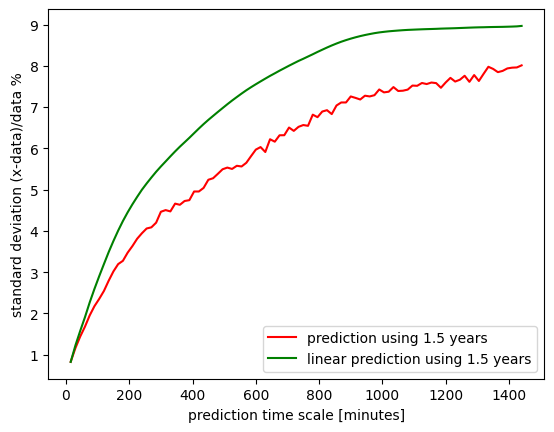

In [66]:
pred_from_2years=np.loadtxt('xgb_1day_v1.txt')
lpred_from_2years=np.loadtxt('linear_1day_v1.txt')
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1.5 years') 
plt.plot(lpred_from_2years[0],100*lpred_from_2years[2]/lpred_from_2years[3],'-',ms=1,color='green',label='linear prediction using 1.5 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
#plt.title("both use a 24 h period for prediction")
plt.ylabel("standard deviation (x-data)/data %")

While for small time scales both perform very similar, XGBoost performs clearly better for larger time scale. Therefore, I concentrate on XGBoost in the following.

First, I XGBoost to the 8 year data set. In both cases the same about 20 weeks are used for tested to avoid that the test period variationsinfluences the result.

In [67]:
predict_intervall(comb_real_power,0,96,96,13250,"xgb",'xgb_1day_8year_v1.txt')

running XGBoost
running prediction over 15 minutes
running prediction over 30 minutes
running prediction over 45 minutes
running prediction over 60 minutes
running prediction over 75 minutes
running prediction over 90 minutes
running prediction over 105 minutes
running prediction over 120 minutes
running prediction over 135 minutes
running prediction over 150 minutes
running prediction over 165 minutes
running prediction over 180 minutes
running prediction over 195 minutes
running prediction over 210 minutes
running prediction over 225 minutes
running prediction over 240 minutes
running prediction over 255 minutes
running prediction over 270 minutes
running prediction over 285 minutes
running prediction over 300 minutes
running prediction over 315 minutes
running prediction over 330 minutes
running prediction over 345 minutes
running prediction over 360 minutes
running prediction over 375 minutes
running prediction over 390 minutes
running prediction over 405 minutes
running prediction

As the next I use the full previous week to predict the following. That should improve the predicting since the scatter obtained after data shifting is smaller for shifting by 1 week than by 1 day. I use the 2 year data set. 

In [ ]:
#still needs to be run again 
#predict_intervall(real_power1,0,96,672,13250,"xgb",'xgb_1week_v1.txt')

I also tried using the previous week with the full 8 year data set. However, that did not work, because of limited memory of my laptop. 

Below I compare the different XGBoost predictions and the different shifts. 

Text(0, 0.5, 'standard deviation (x-data)/data %')

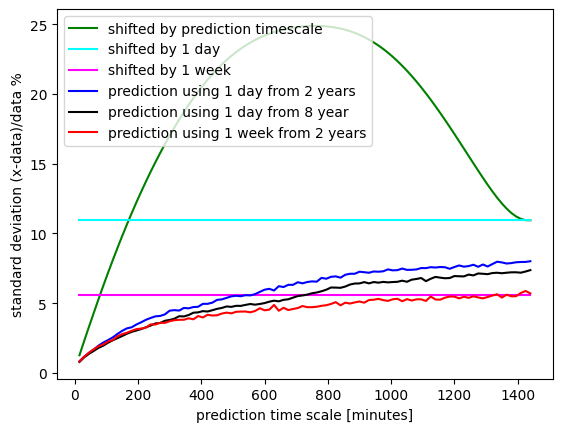

In [73]:
pred_from_2yearsweek=np.loadtxt(path+"xgb_1week_v1b.txt")
pred_from_2years=np.loadtxt('xgb_1day_v1.txt')
pred_from_8years=np.loadtxt('xgb_1day_8year_v1.txt')
plt.plot(pred_from_2years[0],100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 2 years') 
plt.plot(pred_from_8years[0],100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 8 year') 
plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 2 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")


It is visible that already at rather small time scales of 1 hour just using the last data point leads to more than 5 % standard deviation. Using the data from the full last week leads to the best results, at 24 hours it is as good as shifting by 1 week prediction. This is better visible in the zoom plot below.  

Text(0, 0.5, 'standard deviation (x-data)/data %')

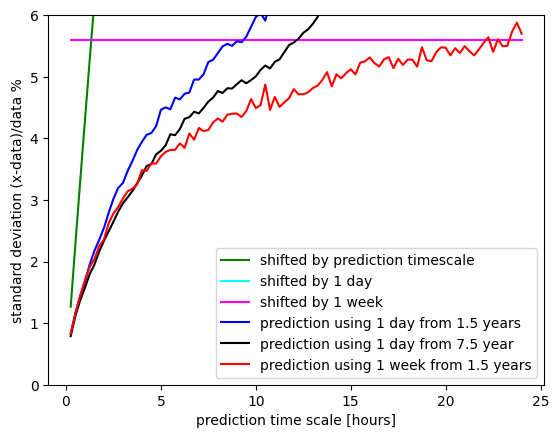

In [74]:
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_8years[0]/60,100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 7.5 year') 
plt.plot(pred_from_2yearsweek[0]/60,100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 1.5 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [hours]")
plt.ylim(0,6)
plt.ylabel("standard deviation (x-data)/data %")

As the next plot, I show the zoom to small time scales.  

(0.0, 5.0)

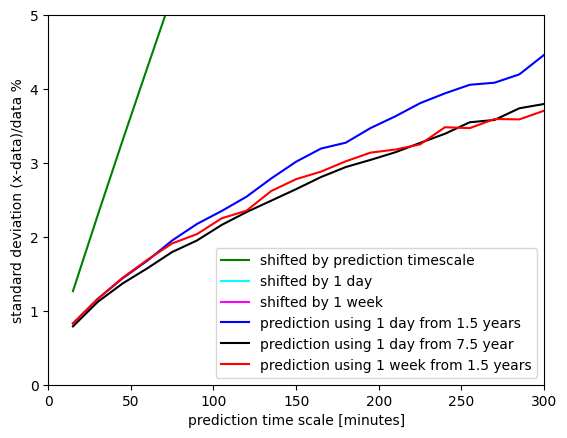

In [78]:
plt.plot(pred_from_2years[0],100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 2 years') 
plt.plot(pred_from_8years[0],100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 8 year') 
plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 2 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")
plt.xlim(0,300)
plt.ylim(0,5)

The prediction which uses 1 day but uses about 8 years of data performs better than both other for time scales smaller than about 4 hours but only by a rather small factor. For more than 4 hours the prediction using 1 week over about 2 years is best. That shows that the week time scale is important for large time scales, on small time scales a prediction which uses only the last day is also good. That is understandable since for small time scales weekday effect and holiday effects or not important; the rerve is true for larger time scales. 

I tried consecutive 15 minutes time scale prediction, because that would be much faster than the several prediction used here. This kind of prediction performs clearly much worse especially for longer time scales. 

Further, I tried to fit pd auto-arima but I could not get to converge. Likely, the fact that this data set has multiple important periods makes that model more difficult to use. 

To consider the several periods at once I now use Multiple Seasonal-Trend decomposition using LOESS (MSTL) which is included in the nwest version of statsmodel.
I always  use the 8 year data set because 2 years are not enough data for a reliable yearly period. 


First, I exclude the test set as usual. 

In [45]:
#start
power_train = comb_real_power.total_power.iloc[:-steps]
power_test  = comb_real_power.total_power.iloc[-steps:]

Then MSTL is then run with the 3 periods and LOESS seasonal degree of 0. The fit takes some time, therefore the result is saved as pickle.  

In [22]:
deg = {"seasonal_deg": 0} 
modelms = MSTL(power_train, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#protected because it takes time
#resms = modelms.fit()
#with open('mstl_v1.pkl', 'wb') as pkl:
#    pickle.dump(resms, pkl)
#other parametsr like box-corr could be optimized

In [37]:
with open(path+'mstl_v1.pkl', 'rb') as f:
    # unpickle
    mstl1 = pickle.load(f)
seasonal = mstl1.seasonal # contains 3 seasonal components
trend = mstl1.trend
residual = mstl1.resid

In [112]:
print(f"standard deviation over the training data set is {round(100*np.std(residual)/np.mean(power_train),2)} %") 

standard deviation over the training data set is 3.76 %


The fit is rather good with abot 3.76 % standard deviation, that is clearly better than shifting by week. We now visilize the long term trend and yearly variation. 

Text(0, 0.5, 'total power [MW]')

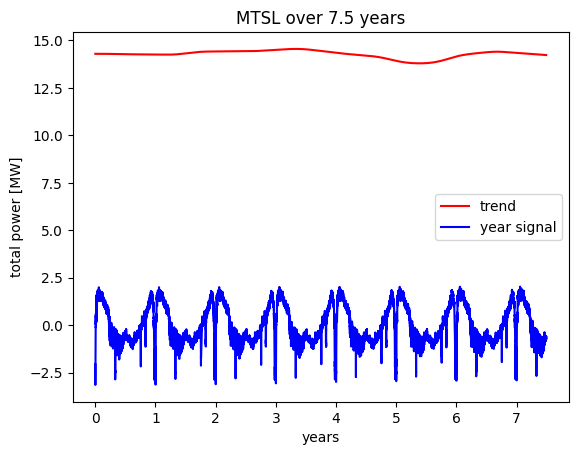

In [39]:
years=np.arange(0,trend.shape[0]/24/4/365.25,1/24/4/365.25)
plt.plot(years,trend,'-',ms=1,color='red',label='trend') 
plt.plot(years,seasonal.iloc[:,2],'-',ms=1,color='blue',label='year signal') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")

The main variation in the year is as expected that is more power needed in the winter. In addition, also holidays, most clearly Christrmas are visible here. 

On the next plot the dayly and weekly variation can be seen. 

(7.0, 14.0)

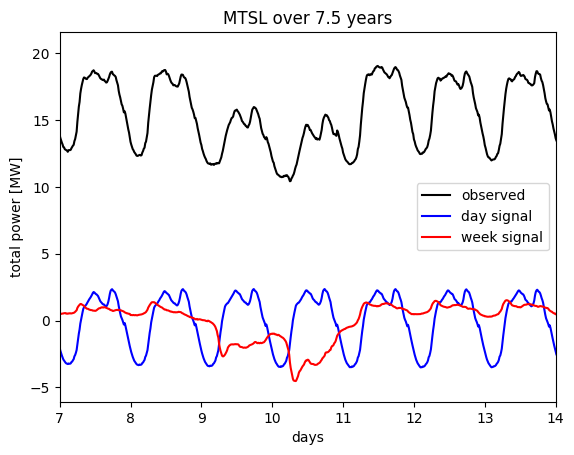

In [114]:
ti2=np.arange(0,262750/24/4,1/24/4)
plt.plot(ti2,power_train,'-',ms=1,color='black',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0],'-',ms=1,color='blue',label='day signal') 
plt.plot(ti2,seasonal.iloc[:,1],'-',ms=1,color='red',label='week signal') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)

Now I compare the total fit with the data. 

(7.0, 14.0)

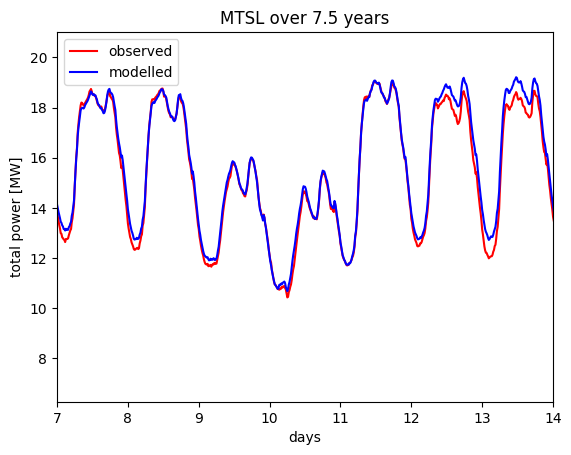

In [121]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)

(190.0, 197.0)

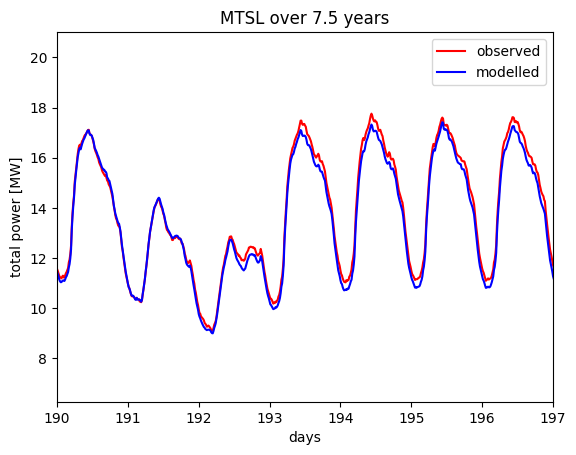

In [117]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")
plt.xlim(190,197)

Usually, the comparison is good. The expection is around Easter and other with it connected holidays, see below, because the date of Eatser is variable. 

(90.0, 100.0)

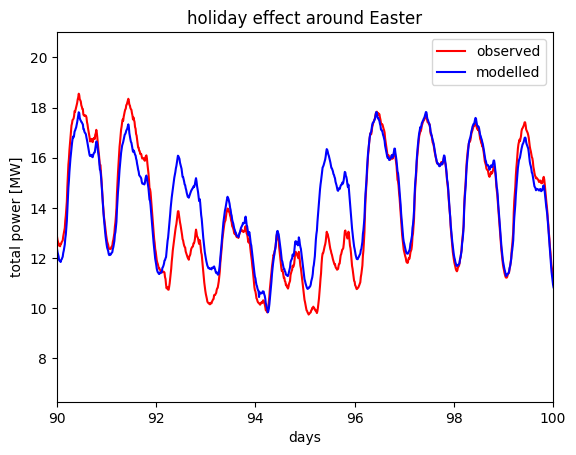

In [118]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("holiday effect around Easter")
plt.ylabel("total power [MW]")
plt.xlim(90,100)

Could get residuals as function of date time of day/week/year to see what is the main problem  

Now I fit all the data. 

In [32]:
#now fitting full data as test how much it chances then and since I am not sure how to predict
deg = {"seasonal_deg": 0} 
modelms = MSTL(comb_real_power.total_power, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#start 9:23
#resms = modelms.fit()
#with open('mstl_v2.pkl', 'wb') as pkl:
#    pickle.dump(resms, pkl)

In [34]:
with open(path+'mstl_v2.pkl', 'rb') as f:
    # unpickle
    resms2 = pickle.load(f)
seasonal2 = resms2.seasonal # contains 3 seasonal components
trend2 = resms2.trend
residual2 = resms2.resid 

Text(0, 0.5, 'total power [MW]')

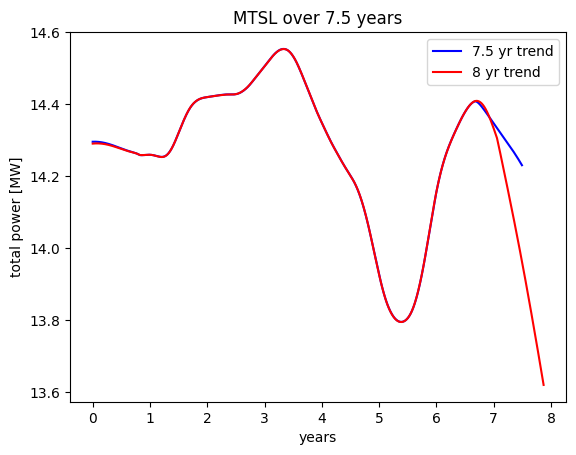

In [41]:
years2=np.arange(0,trend2.shape[0]/24/4/365.25,1/24/4/365.25)
plt.plot(years,trend,'-',ms=1,color='blue',label='7.5 yr trend') 
plt.plot(years2,trend2,'-',ms=1,color='red',label='8 yr trend') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 7.5 years")
plt.ylabel("total power [MW]")


In the most recent data there is a difference in the trend. This does not matter for testing MSTL, because that is a nearly constant offset which can be easily modelled with little data. 

I now I look into the deviation between the year term


0.23 % deviation for week model
0.09 % deviation for week model in 8th year


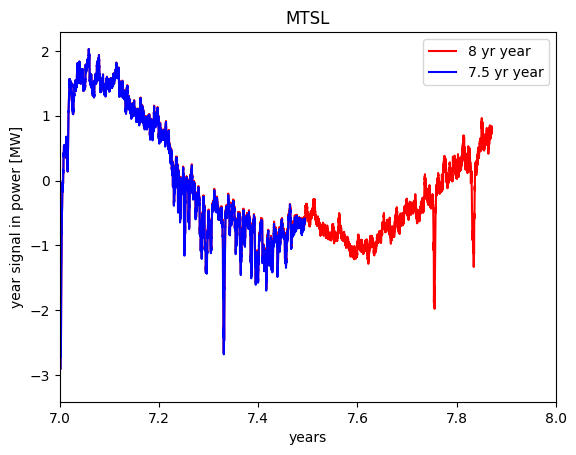

In [46]:
plt.plot(years2,seasonal2.iloc[:,2],'-',ms=1,color='red',label='8 yr year') 
plt.plot(years,seasonal.iloc[:,2],'-',ms=1,color='blue',label='7.5 yr year') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL")
plt.ylabel("year signal in power [MW]")
plt.xlim(7,8)


There is none visiually. Therefor, I now caluclate the difference quantiatively.

In [89]:
print("standard deviation bewteen seasonal models for the diffrence periods")
print(f"{round(np.std(seasonal.iloc[:,2]-seasonal2.iloc[:trend.shape[0],2])/np.mean(power_train)*100,2)} % deviation for year model")
print(f"{round(np.std(seasonal.iloc[245448:,2]-seasonal2.iloc[245448:trend.shape[0],2])/np.mean(power_train)*100,2)} % deviation for year model in 8th year")
print(f"{round(np.std(seasonal.iloc[:,1]-seasonal2.iloc[:trend.shape[0],1])/np.mean(power_train)*100,2)} % deviation for week model")
print(f"{round(np.std(seasonal.iloc[245448:,1]-seasonal2.iloc[245448:trend.shape[0],1])/np.mean(power_train)*100,2)} % deviation for week model in 8th year")
print(f"{round(np.std(seasonal.iloc[:,0]-seasonal2.iloc[:trend.shape[0],0])/np.mean(power_train)*100,2)} % deviation for day model")
print(f"{round(np.std(seasonal.iloc[245448:,0]-seasonal2.iloc[245448:trend.shape[0],0])/np.mean(power_train)*100,2)} % deviation for day model in 8th year")

standard deviation bewteen seasonal models for the diffrence periods
0.23 % deviation for year model
0.09 % deviation for year model in 8th year
0.06 % deviation for week model
0.2 % deviation for week model in 8th year
0.02 % deviation for day model
0.03 % deviation for day model in 8th year


The deviation for of year, week and day models are small at most 0.23%. Thus using the full data for training MTSL has only a very minor impact on model testing. The day resiual is very small which means that the impact on the prediction below which uses only the last 1-2 day is very small.  

The deviation ssem small but it needs comapred with how good the model is. That is calculated in the following

In [91]:
residual2_train = residual2.iloc[:-steps]
residual2_test  = residual2.iloc[-steps:]
print("standard deviation of residua after MTSL fitting")
print(f"train: {round(100*np.std(residual2_train)/np.mean(power_train),2)}% test: {round(100*np.std(residual2_test)/np.mean(power_test),2)}%")

standard deviation of residua after MTSL fitting
train: 3.76% test: 2.86%


This scatter is more than 10 times larger. Thus, the differences between the sesonal models do not matter and the trend difefrence is not relevant for short and medium term prediction. 

The scatter is smaller in the test data set than in train set. Thus there is likely no overfitting of MTSL. Likely, also contributing to the sign of the difference is that the main movable holidays associated with Easter are in the first half of the year which is not in test. 

As the next step I try to further optimize the prediction by using the following models on the residual:
1. Shifting just to the last data allowed
2. linear regression
3. XGboost

In [54]:
residua=residual2.to_numpy()

First for linear regression as before each number of explore future prediction step (15 minutes to 1 day) separately. 

In [63]:
resf=np.zeros((4,96))
steps = 13250
for i in range(96):
    print(f"prediction for {i} steps")
    res3=series_to_supervised(residua,96,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:96]
    x3_test=dataa3_test.iloc[:,0:96]
    y3_train=dataa3_train.iloc[:,96]
    y3_test=dataa3_test.iloc[:,96]
    resf[0,i]=15*(i+1)
    linear=LinearRegression()
    linear.fit(x3_train,y3_train)
    pred3=linear.predict(x3_test)
    diff6=y3_test.shift(periods=i+1) #this shifts the data using the last allowed data point
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    np.savetxt('linear_1day_8yr_mtsl_residua_v1.txt',resf)  #written out was 1.txt

prediction for 0 steps
prediction for 1 steps
prediction for 2 steps
prediction for 3 steps
prediction for 4 steps
prediction for 5 steps
prediction for 6 steps
prediction for 7 steps
prediction for 8 steps
prediction for 9 steps
prediction for 10 steps
prediction for 11 steps
prediction for 12 steps
prediction for 13 steps
prediction for 14 steps
prediction for 15 steps
prediction for 16 steps
prediction for 17 steps
prediction for 18 steps
prediction for 19 steps
prediction for 20 steps
prediction for 21 steps
prediction for 22 steps
prediction for 23 steps
prediction for 24 steps
prediction for 25 steps
prediction for 26 steps
prediction for 27 steps
prediction for 28 steps
prediction for 29 steps
prediction for 30 steps
prediction for 31 steps
prediction for 32 steps
prediction for 33 steps
prediction for 34 steps
prediction for 35 steps
prediction for 36 steps
prediction for 37 steps
prediction for 38 steps
prediction for 39 steps
prediction for 40 steps
prediction for 41 steps
pr

Now I do the same for xgboost. 

In [36]:
resf=np.loadtxt('xgb_1day_8yr_mtsl_residua_v1.txt')
steps = 13250
for i in range(95,96):
    print(i)
    res3=series_to_supervised(residua,96,i)
    res3=pd.DataFrame(res3)
    dataa3_train = res3.iloc[:-steps,:]
    dataa3_test  = res3.iloc[-steps:,:]
    x3_train=dataa3_train.iloc[:,0:96]
    x3_test=dataa3_test.iloc[:,0:96]
    y3_train=dataa3_train.iloc[:,96]
    y3_test=dataa3_test.iloc[:,96]
    resf[0,i]=15*(i+1)
    xmodel3=XGBRegressor()
    xmodel3.fit(x3_train,y3_train)
    pred3=xmodel3.predict(x3_test)
    diff6=y3_test.shift(periods=i+1) #this shifts the data using the last allowed data point
    resf[2,i]=np.std(pred3-y3_test)
    resf[1,i]=np.std(diff6-y3_test)
    resf[3,i]=np.mean(y3_test)
    np.savetxt('xgb_1day_8yr_mtsl_residua_v1b.txt',resf)  #written out was 1.txt

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [ ]:
Now I am loading the different fits. 

In [69]:
resf2=np.loadtxt(path+"xgb_1week_v1b.txt")
resf=np.loadtxt(path+"xgb_1day_v1.txt")
resf8=np.loadtxt(path+'xgb_1day_8yr_v1.txt')
resfm=np.loadtxt(path+'xgb_1day_8yr_mtsl_residua_v1.txt')
resfl=np.loadtxt('linear_1day_8yr_mtsl_residua_v1.txt')

Now I plot the different predictions. 

Text(0, 0.5, 'standard deviation (x-data)/data %')

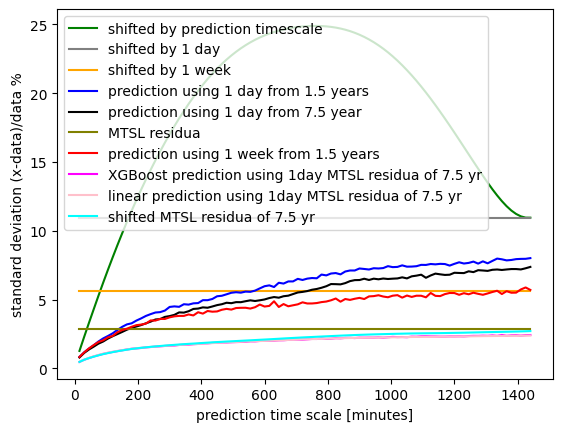

In [79]:
plt.plot(pred_from_2years[0],100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='gray',label='shifted by 1 day')
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='orange',label='shifted by 1 week') 
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_8years[0],100*pred_from_8years[2]/pred_from_8years[3],'-',ms=1,color='black',label='prediction using 1 day from 7.5 year') 
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(residual2_test)/np.mean(power_test),'-',ms=1,color='olive', label='MTSL residua')
plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 1.5 years') 
plt.plot(resfm[0],100*resfm[2]/resf[3],'-',ms=1,color='magenta',label='XGBoost prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfl[0],100*resfl[2]/resf[3],'-',ms=1,color='pink',label='linear prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfm[0],100*resfm[1]/resf[3],'-',ms=1,color='cyan',label='shifted MTSL residua of 7.5 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")

All resida fittingmethods arte better than the diredct data method. 
The improvement is smallest on the smallest time scales where the not (well) accounting for the periodicity in the 
other models has no large impact. From about 3 hours onwards the pure MTSL model is better than all methods which do not use it. 

I am now zooming into the better predictions.

worst over fitting factor of xgboost 1.019545
worst over fitting factor of linear regression 1.03257
best fitting factor of xgboost 0.886654
best fitting factor of linear regression 0.880331


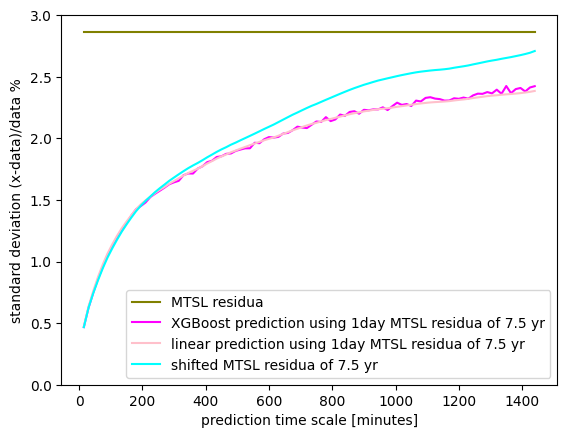

In [87]:
plt.plot(pred_from_2years[0],0*pred_from_2years[1]+100*np.std(residual2_test)/np.mean(power_test),'-',color='olive', label='MTSL residua')
plt.plot(resfm[0],100*resfm[2]/resf[3],'-',ms=1,color='magenta',label='XGBoost prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfl[0],100*resfl[2]/resf[3],'-',ms=1,color='pink',label='linear prediction using 1day MTSL residua of 7.5 yr')
plt.plot(resfm[0],100*resfm[1]/resf[3],'-',ms=1,color='cyan',label='shifted MTSL residua of 7.5 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")
plt.ylim(0,3)
print(f"worst over fitting factor of xgboost {round(max(resfm[2]/resfm[1]),6)}")
print(f"worst over fitting factor of linear regression {round(max(resfl[2]/resfl[1]),6)}")
print(f"best fitting factor of xgboost {round(min(resfm[2]/resfm[1]),6)}")
print(f"best fitting factor of linear regression {round(min(resfl[2]/resfl[1]),6)}")

XGBoost, linear regression and just shifting perform rather similar for smaller scale prediction. Sometimes just shifting is better, but only by to 3 %. Since xgboost and linear regression should in the worst case have the same performance it means that there is overfitting.

From about 5 hours the fits are better than just shifting, by up to 12%. The linbear prediction looks smoother is th=use probably better.  Just shifting also improves the fit for all time scales considered here. 

In [ ]:
#more improvement? add price (best short I assume), add holiday, weekday for medium term (but most should be already be included)
#try MTSL variants, understand MTSL forecast